<a href="https://colab.research.google.com/github/AyushGupta51379/COMP_5331_Project_Fake_News_Detection/blob/master/pixel_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

testing github... uploading to pixel-team branch...

# Upload datasets to google drive and mount it on Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls 'drive/My Drive/COMP5331 Fall 2020/MM17-WeiboRumorSet/nonrumor_images/'

593bbc68gw1eyk2v8xuojj20bj08maaz.jpg  652f5916jw1eyybrvmew9j20a00kcacg.jpg
61d83ed4jw1ewdp2nmruwj20c80c8wfi.jpg  655dd5f3gw1ezoxhrh0igj20c8085t9r.jpg
61e6c012gw1ezs1aot0x3j20bm0ahjry.jpg  6693ce84gw1eygikng2bej20c88xikjl.jpg
620beb06gw1eyaur3h31qj20c808nq3d.jpg  6a918093jw1ewlulkenpqj20c8085gmv.jpg
62b31d36gw1eyttnhk3s3j20qq0jjtbr.jpg  75b52ed2jw1ewtuvcmuboj20it0sgtar.jpg
652f5916jw1eyuetx8i4ej20b90cq75v.jpg


In [ ]:
import torch                       # pytorch
import torch.nn as nn              # pytorch for neural network
import torchvision
from torchvision import datasets, transforms # for loading and transform images to tensor
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt    # to plot graph

# Read all images, resize images into (100,100), convert into tensor type

Reference/Tutorial
- A Beginner’s Tutorial on Building an AI Image Classifier using PyTorch **(from data loading, processing to training and evaluation)**
   - https://towardsdatascience.com/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7

In [ ]:
mainfolder = 'drive/My Drive/COMP5331 Fall 2020/MM17-WeiboRumorSet/'

mytransform = transforms.Compose([transforms.Resize((100,100), interpolation=Image.NEAREST),   # to resize our source images
                                  transforms.ToTensor()])                                      # then convert into tensor image

dataset = datasets.ImageFolder(mainfolder, transform= mytransform) # NOTE: The path should point a place with subfolders (which contains images inside).
                                                                                  #  It will report bug if there is no subfolder.

labels = dataset.class_to_idx # the dataset saves the subfolder's name as the labels
# print(labels) 
# print(type(labels))

classes = list(labels.keys()) # convert dict keys into list
print(classes)

# print(type(dataset))
print('No. of images: ', len(dataset))

['nonrumor_images', 'rumor_images', 'tweets']
No. of images:  18


In [ ]:
# creating function to view image
def image_show(np_image):
  plt.figure(figsize = (5,5))
  plt.imshow(np_image) # it should be a numpy array
  plt.show()

# Load training set

---------
E.g., images.shape = (4, 3, 100, 100)

4 - Batch Size(no. of images loaded),

3 - channels in input,

100, 100 - shape of individual image

---------


torch.Size([4, 3, 100, 100])
torch.Size([3, 100, 100])
rumor_images


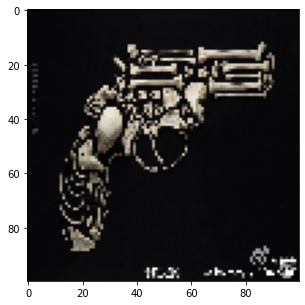

In [ ]:
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 4, shuffle = True) 

data_iter = iter(trainloader)
images,labels = data_iter.__next__() 

# view original image
print(images.shape)
np_image = images[0].numpy() #converting tensor --> numpy
np_image = np.transpose(np_image, (1,2,0))
print(classes[labels[0]])
image_show(np_image)


# Pixel-domain Network

`nn.Conv2d(in_channels, out_channels, kernel_size, ...)`
  - It seems we have to specify the in_channels *manually*

`nn.MaxPool2d(kernel_size, ...`

*   kernel_size = 3 --> 3 x 3
- Max pooling: The maximum pixel value of the batch is selected (among all input channels?).
- Min pooling: The minimum pixel value of the batch is selected.
- Average pooling: The average value of all the pixels in the batch is selected.

`nn.Linear(in_features, out_features, ...`

---
**Reference/Tutorial**
- Understand how kernels work in Conv2d and pooling
  -  https://stats.stackexchange.com/questions/296679/what-does-kernel-size-mean#:~:text=Deep%20neural%20networks%2C%20more%20concretely,layer%2C%20are%20the%20convolutional%20filters.

- Convolution Neural Network (CNN)
  -  https://towardsdatascience.com/convolutional-neural-network-17fb77e76c05#:~:text=Fully%20Connected%20Layer%20is%20simply,into%20the%20fully%20connected%20layer.
- What do the fully connected layers do in CNN?
  -  https://stats.stackexchange.com/questions/182102/what-do-the-fully-connected-layers-do-in-cnns/182122

In [ ]:
class PixelNet(nn.Module):
    def __init__(self):
        # Conv Model 1
        self.conv_M1 = nn.Sequential(nn.Conv2d(3,  32, 3), nn.ReLU(), # ReLu --> nonlinear Activation Function used in the paper (Qi et al. 2019)
                                     nn.Conv2d(32, 32, 1), nn.ReLU(), # The paper does not mention padding. Assume no padding (output dim shd be a bit smaller).
                                     nn.MaxPool2d(2, stride=1))       
        # Conv Model 2
        self.conv_M2 = nn.Sequential(nn.Conv2d(3,  64, 3), nn.ReLU(),
                                     nn.Conv2d(64, 64, 1), nn.ReLU(),
                                     nn.MaxPool2d(2, stride=1))
        # Conv Model 3
        self.conv_M3 = self.conv_model_2

        # Conv Model 4
        self.conv_M4 = nn.Sequential(nn.Conv2d(64,  128, 3), nn.ReLU(),
                                     nn.Conv2d(128, 128, 1), nn.ReLU(),
                                     nn.MaxPool2d(2, stride=1))
        
        # For each branch
        self.conv_br1 = nn.Sequential(nn.Conv2d(32, 64, 1),
                                      nn.Flatten(0, -1),              # need to flatten input into vector before the FC layer
                                      nn.Linear(64*100*100, 64))      # A fully connected (FC) layer: 64 conv channels x (100 x 100) <-- image size

        self.conv_br2 = nn.Sequential(nn.Conv2d(64, 64, 1),
                                      nn.Flatten(0, -1),              
                                      nn.Linear(64*100*100, 64))      

        self.conv_br3 = nn.Sequential(nn.Conv2d(64, 64, 1),
                                      nn.Flatten(0, -1),              
                                      nn.Linear(64*100*100, 64))      

        self.conv_br4 = nn.Sequential(nn.Conv2d(128, 64, 1),
                                      nn.Flatten(0, -1),              
                                      nn.Linear(64*100*100, 64))      

    def forward(self, x):
        out1 = self.conv_M1(x)      # Branch 1
        out2 = self.conv_M1(out1)   # Branch 2
        out3 = self.conv_M1(out2)   # Branch 3
        out4 = self.conv_M1(out3)   # Branch 4

        out_br1 = self.conv_br1(out1)
        out_br2 = self.conv_br2(out2)
        out_br3 = self.conv_br3(out3)
        out_br4 = self.conv_br4(out4)

        return out1, out2, out3, out4

In [ ]:
net = PixelNet()
# defining Loss function
loss_func = nn.CrossEntropyLoss()
# defining optimizer
optimizer = torch.optim.Adam(net.parameters()) 

# Below are just sample code from online tutorial

In [ ]:
def model_eval(dataloader):
    total = 0
    correct = 0
    for data in dataloader:
        images, labels = data
        out = net(images)
        print(out.shape)
        max_val, preds = torch.max(out,dim=1)
        #accuracy = (correctly predicted class / total testing class) × 100%
        total += labels.shape[0]                   # class value 
        correct += (preds == labels).sum().item()  # to summ correct in the batch then sum all of it
        accuracy = (100 * correct)/total
    return accuracy 

In [ ]:
epoch = 2
for i in range(epoch):

  for data in trainloader:  #Each time there is a batch size of 4 for each training step to update the model parameters
    image_data , labels = data
    print(image_data.shape)
    optimizer.zero_grad() 
    out = net(image_data) #image_data --> input data

  train_acc = model_eval(trainloader) 
  test_acc  = model_eval(testloader)

  print("Epoch :",i," Test Accuracy : ",test_acc," Train Accuracy : ",train_acc)